# Sagemaker Training Pipelines

## Overview of ML Workflow

In this notebook, we outline the key steps in the machine learning workflow using Amazon SageMaker. The process involves training an XGBoost model with the following steps:

1. **Data Preprocessing:** The raw data is cleaned and transformed to create features, and then it is split into training, validation, and test datasets.
2. **Hyperparameter Tuning:** The model's hyperparameters are tuned using SageMaker's XGBoost framework to find the best-performing model, with the AUC score as the metric for evaluation.
3. **Model Evaluation:** The trained model is evaluated using the test dataset, and the AUC score is compared against a predefined threshold to assess performance.
4. **Model Registration:** If the model meets the threshold AUC score, it is registered in the SageMaker model registry for further use in deployment.

This notebook walks through the process of setting up, training, and evaluating the model, ensuring that we achieve optimal performance before registering it for deployment.

#### Installing Required Libraries

In [1]:
# Install or upgrade the boto3 library, which is used to interact with AWS services
!pip install --upgrade boto3

# Install openpyxl library to work with Excel files
!pip install openpyxl

# Install diagrams library to help create architecture diagrams
!pip install diagrams

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 147.3 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.162
    Uninstalling botocore-1.34.162:
      Successfully uninstalled botocore-1.34.162
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.162
    Uninstalling boto3-1.34.162:
      Successfully uninstalled boto3-1.34.162
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.13.3 requires botocore<1.34.163,>=1.34.70, but you have botocore 1.35.63 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
au

#### High-Level ML Workflow Architecture

This diagram represents the high-level architecture of the machine learning workflow. The workflow consists of several key steps to train the model efficiently using Amazon SageMaker.

The **Train Pipeline** includes the following steps:

1. **Preprocess Data:** The first step involves preprocessing the raw data to build the necessary features and split it into train, validation, and test datasets.
2. **Hyperparameter Tuning:** This step involves tuning the model’s hyperparameters using the SageMaker XGBoost framework, aiming to find the best model based on the highest AUC score.
3. **Model Evaluation:** After training, the model is evaluated on the test dataset to ensure it meets the required AUC score, which indicates the model's performance.
4. **Model Registration:** If the model's AUC score meets the predefined threshold, it is then registered into the SageMaker model registry for future use.

##### ML Workflow Diagram

The following diagram illustrates the machine learning workflow, from data storage to model registration, with key steps in the process:

In [17]:
from diagrams import Diagram, Edge
from diagrams.aws.storage import S3
from diagrams.aws.ml import Sagemaker
from diagrams.aws.management import Cloudwatch

with Diagram("High-Level ML Workflow Architecture", show=False, direction="LR"):
    # Components
    s3 = S3("S3 Bucket")

    preprocessing = Sagemaker("Preprocess Data")
    tuning = Sagemaker("Hyperparameter Tuning")
    evaluation = Sagemaker("Model Evaluation")
    condition = Sagemaker("Check AUC Score")
    register_model = Sagemaker("Register Model")
    model_registry = Sagemaker("Model Registry")

    # Workflow
    s3 >> preprocessing >> tuning >> evaluation >> condition
    condition >> Edge(label="AUC > Threshold") >> register_model >> model_registry



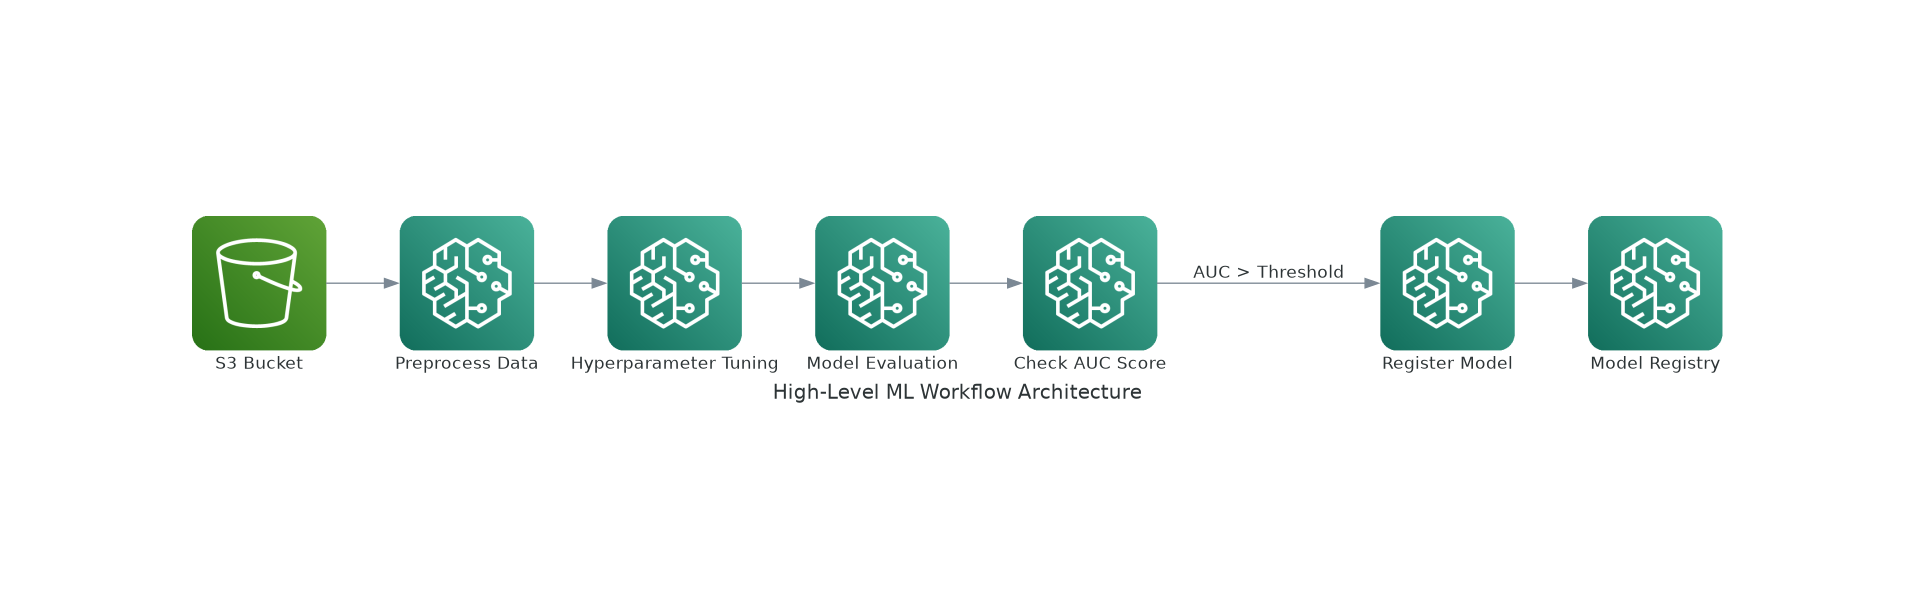

In [18]:
from IPython.display import Image
Image(filename="high-level_ml_workflow_architecture.png")

## Build Pipeline Components

### Pre-requisites

#### Initializing AWS Services and SageMaker Session

In this step, we initialize the necessary AWS services and set up the SageMaker session. We create an S3 client to interact with Amazon S3, define the pipeline name, and set up the SageMaker session for interacting with the SageMaker environment. Additionally, we retrieve the execution role, region, and default S3 bucket for storing data and models. These configurations are crucial for running the pipeline and managing resources.

In [4]:
# Import necessary libraries for AWS and SageMaker operations
import boto3
import pandas as pd
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

# Initialize the S3 client to interact with S3 buckets
s3_client = boto3.resource('s3')

# Define the pipeline name for training
pipeline_name = f"sagemaker-mlops-train-pipeline"

# Create a SageMaker session object to interact with SageMaker
sagemaker_session = sagemaker.Session()

# Get the current region for AWS resources
region = sagemaker_session.boto_region_name

# Get the execution role for SageMaker to access AWS resources
role = sagemaker.get_execution_role()

# Initialize a pipeline session object to manage the workflow
pipeline_session = PipelineSession()

# Get the default S3 bucket for the SageMaker session to store data and models
default_bucket = sagemaker_session.default_bucket()

# Define the model package group name for version control in the model registry
model_package_group_name = f"ChurnModelPackageGroup"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


#### Defining Workflow Parameters

In this step, we define the parameters required for the machine learning workflow. These parameters include the number of processing instances, instance types for training and processing, the input data file, and the model approval status. Additionally, we set a threshold for the AUC score to evaluate the model's performance. These parameters allow us to configure the pipeline dynamically and modify the workflow as needed.

In [5]:
# Import necessary classes for defining parameters in the workflow
from sagemaker.workflow.parameters import (
    ParameterInteger, 
    ParameterString, 
    ParameterFloat
)

# Set the AUC score threshold for model evaluation
auc_score_threshold = 0.75

# Define the base job prefix for naming SageMaker jobs
base_job_prefix = "churn-example"

# Define the number of processing instances (default to 1)
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

# Define the instance type for processing (default to 'ml.m5.xlarge')
processing_instance_type = ParameterString(name="ProcessingInstanceType", default_value="ml.m5.xlarge")

# Define the instance type for training (default to 'ml.m5.xlarge')
training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")

# Specify the input data file for the training process
input_data = "storedata_total.csv"

# Define the model approval status (default to 'PendingManualApproval')
model_approval_status = ParameterString(name="ModelApprovalStatus", default_value="PendingManualApproval")


### Collect & Prepare Data

#### Downloading the Dataset

In [ ]:
# Use wget to download the dataset from the GitHub repository
!wget --no-check-certificate https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/main/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx

--2024-11-18 15:20:36--  https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx [following]
--2024-11-18 15:20:36--  https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/dataset/storedata_total.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

#### Converting Excel Data to CSV Format

In this step, we load the Excel dataset using pandas and convert it into a CSV format. This will allow us to work with the data more easily in the SageMaker pipeline, as CSV is a common format for training machine learning models.

In [7]:
# Load the dataset from the downloaded Excel file
store_data = pd.read_excel("storedata_total.xlsx")

# Convert the dataset into a CSV format and save it as "storedata_total.csv"
store_data.to_csv("storedata_total.csv", index=False)

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Defining the PreProcessing Step (Preprocess Data) in SageMaker Pipeline

#### Downloading the Preprocessing Script

In this step, we download the preprocessing script (preprocess-churn.py) from the GitHub repository. This script will be used in the preprocessing step of the SageMaker pipeline to transform and prepare the data for model training.

In [ ]:
# Use wget to download the preprocessing script from the GitHub repository
!wget --no-check-certificate https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/main/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py

--2024-11-18 15:20:50--  https://github.com/garganshulgarg/learn-mlops-with-sagemaker/raw/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py [following]
--2024-11-18 15:20:50--  https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/preprocess-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent

#### Viewing the Preprocessing Script

In this step, we use pygmentize to display the content of the preprocess-churn.py script in a more readable, highlighted format. This helps us review the script to understand the preprocessing logic before using it in the SageMaker pipeline.

In [9]:
# Use pygmentize to display the content of the preprocessing script with syntax highlighting
!pygmentize "preprocess-churn.py"

import os
import tempfile
import numpy as np
import pandas as pd
import datetime as dt
if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    #Read Data
    df = pd.read_csv(
        f"{base_dir}/input/storedata_total.csv"
    )
    # convert created column to datetime
    df["created"] = pd.to_datetime(df["created"])
    #Convert firstorder and lastorder to datetime datatype
    df["firstorder"] = pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    #Drop Rows with Null Values
    df = df.dropna()
    #Create column which gives the days between the last order and the first order
    df['first_last_days_diff'] = (df['lastorder'] - df['firstorder']).dt.days
    #Create column which gives the days between the customer record was created and the first order
    df['created_first_days_diff'] = (df['created'] - df['firstorder']).dt.days
    #Drop columns
    df.drop(['custid', 'created','firstorder','lastorder

#### Defining the Feature Engineering PreProcessing Step

In this step, we define the Feature Engineering processing step within the SageMaker pipeline. The feature engineering step is responsible for preparing the features required for model training. We use the SKLearnProcessor to run the preprocess-churn.py script, which performs data preprocessing and splits the data into training, validation, and test sets. The outputs are stored in S3 for later use in the model training step.

In [10]:
# Import necessary libraries for defining the processing step
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

# Define the framework version and SKLearnProcessor for feature engineering
framework_version = "1.0-1"
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,  # Use ml.m5.xlarge instance type for processing
    instance_count=processing_instance_count,  # Number of instances for processing
    base_job_name="sklearn-churn-process",  # Prefix for the job names
    role=role,  # Execution role for SageMaker
    sagemaker_session=pipeline_session,  # SageMaker session to run the job
)

# Define the processing step inputs and outputs
processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  # Input data
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train", 
                         destination=f"s3://{default_bucket}/output/train"),  # Training data output
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation", 
                         destination=f"s3://{default_bucket}/output/validation"),  # Validation data output
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test", 
                         destination=f"s3://{default_bucket}/output/test"),  # Test data output
    ],
    code="preprocess-churn.py",  # Path to the preprocessing script
)

# Define the processing step in the pipeline
step_process = ProcessingStep(name="ChurnModelProcess", step_args=processor_args)


The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is interpreted in pipeline execution time only. As the function needs to evaluate the argument value in SDK compile time, the default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.
/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Defining the Model Training Step

In this step, we define the model training step using the SageMaker XGBoost framework. The XGBoost algorithm is configured with fixed hyperparameters for binary classification and is trained to optimize the AUC metric. The model artifact is saved to an S3 bucket for further evaluation and deployment. This step prepares the environment for hyperparameter tuning and training.

In [12]:
# Import necessary libraries for defining the training step and hyperparameter tuning
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.workflow.steps import TuningStep

# Define the S3 path where the model artifact will be stored
model_path = f"s3://{default_bucket}/output"

# Retrieve the XGBoost Docker image URI for the specific framework and instance type
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",  # Specify the XGBoost framework
    region=region,  # AWS region
    version="1.0-1",  # Framework version
    py_version="py3",  # Python version
    instance_type=training_instance_type,  # Instance type
)

# Define fixed hyperparameters for the XGBoost algorithm
fixed_hyperparameters = {
    "eval_metric": "auc",  # Metric to evaluate model performance
    "objective": "binary:logistic",  # Objective for binary classification
    "num_round": "100",  # Number of training rounds
    "rate_drop": "0.3",  # Dropout rate
    "tweedie_variance_power": "1.4",  # Tweedie variance parameter
}

# Define the XGBoost Estimator for training
xgb_train = Estimator(
    image_uri=image_uri,  # XGBoost image URI
    instance_type=training_instance_type,  # Instance type for training
    instance_count=1,  # Number of instances for training
    hyperparameters=fixed_hyperparameters,  # Fixed hyperparameters
    output_path=model_path,  # Output path for model artifacts
    base_job_name="churn-train",  # Prefix for the training job name
    sagemaker_session=pipeline_session,  # SageMaker session
    role=role,  # Execution role
)

The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is interpreted in pipeline execution time only. As the function needs to evaluate the argument value in SDK compile time, the default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


### Defining the Hyperparameter Tuning Step in SageMaker Pipeline

In this step, we define the Hyperparameter Tuning step for the SageMaker pipeline. Hyperparameter tuning helps optimize the model's performance by searching for the best combination of hyperparameters using the SageMaker XGBoost framework. The model is evaluated using the AUC metric on the validation dataset, and the best model is identified for further steps.

In [13]:
# Define the range of hyperparameters to tune
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),  # Learning rate range
    "min_child_weight": ContinuousParameter(1, 10),  # Minimum sum of instance weight (hessian)
    "alpha": ContinuousParameter(0, 2),  # L1 regularization term range
    "max_depth": IntegerParameter(1, 10),  # Range for maximum tree depth
}

# Define the objective metric for tuning
objective_metric_name = "validation:auc"  # AUC metric on validation data

# Configure the HyperparameterTuner
tuner = HyperparameterTuner(
    estimator=xgb_train,  # XGBoost estimator
    objective_metric_name=objective_metric_name,  # Metric to optimize
    hyperparameter_ranges=hyperparameter_ranges,  # Hyperparameter ranges
    max_jobs=2,  # Maximum number of tuning jobs
    max_parallel_jobs=2,  # Maximum number of parallel jobs
)

# Define the arguments for the hyperparameter optimization job
hpo_args = tuner.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",  # Specify the content type
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
            content_type="text/csv",  # Specify the content type
        ),
    }
)

# Define the TuningStep for the SageMaker pipeline
step_tuning = TuningStep(
    name="ChurnHyperParameterTuning",  # Name of the tuning step
    step_args=hpo_args,  # Arguments for the tuning job
)

### Defining the Model Evaluation Step in SageMaker Pipeline

#### Downloading the Model Evaluation Script

In this step, we download the model evaluation script (evaluate-churn.py) from the GitHub repository. This script will be used in the pipeline to evaluate the trained model's performance using the test dataset and compute metrics such as AUC to determine its effectiveness.

In [ ]:
!wget --no-check-certificate https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/head/main/sapplications/4-sagemaker-model-train-pipeline/evaluate-churn.py

--2024-11-18 15:30:36--  https://raw.githubusercontent.com/garganshulgarg/learn-mlops-with-sagemaker/refs/heads/sagemaker-train-pipeline/applications/4-sagemaker-model-train-pipeline/evaluate-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1309 (1.3K) [text/plain]
Saving to: ‘evaluate-churn.py’

evaluate-churn.py   100%[===================>]   1.28K  --.-KB/s    in 0s      

2024-11-18 15:30:36 (72.3 MB/s) - ‘evaluate-churn.py’ saved [1309/1309]



In [15]:
!pygmentize "evaluate-churn.py"

import json
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost
import datetime as dt
from sklearn.metrics import roc_curve,auc
if __name__ == "__main__":   
    #Read Model Tar File
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    model = pickle.load(open("xgboost-model", "rb"))
    #Read Test Data using which we evaluate the model
    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)
    X_test = xgboost.DMatrix(df.values)
    #Run Predictions
    predictions = model.predict(X_test)
    #Evaluate Predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_score = auc(fpr, tpr)
    report_dict = {
        "classification_metrics": {
            "auc_score": {
                "value": auc_score,


#### Defining the Model Evaluation Step

This step defines the Model Evaluation step in the SageMaker pipeline. Using a ScriptProcessor, the trained model is evaluated on the test dataset. The evaluation script computes performance metrics, such as the AUC score, to determine whether the model meets the required quality standards. The evaluation results are saved in an S3 bucket as a JSON report.

In [16]:
# Import required library for the ScriptProcessor
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.properties import PropertyFile

# Define the ScriptProcessor to evaluate the model
script_eval = ScriptProcessor(
    image_uri=image_uri,  # XGBoost Docker image URI
    command=["python3"],  # Command to execute the evaluation script
    instance_type=processing_instance_type,  # Instance type for processing
    instance_count=1,  # Number of instances
    base_job_name="script-churn-eval",  # Prefix for the evaluation job name
    role=role,  # Execution role
    sagemaker_session=pipeline_session,  # SageMaker session
)

# Define the arguments for the evaluation script
eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_tuning.get_top_model_s3_uri(top_k=0, s3_bucket=default_bucket, prefix="output"),
            destination="/opt/ml/processing/model",  # Location to load the best model
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",  # Location to load the test dataset
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation", 
            source="/opt/ml/processing/evaluation",  # Directory for evaluation output
            destination=f"s3://{default_bucket}/output/evaluation",  # S3 bucket path
        ),
    ],
    code="evaluate-churn.py",  # Path to the evaluation script
)

# Define a PropertyFile to capture evaluation results
evaluation_report = PropertyFile(
    name="ChurnEvaluationReport",  # Name of the evaluation report
    output_name="evaluation",  # Output name matching the ProcessingOutput
    path="evaluation.json",  # Path to the JSON report
)

# Define the ProcessingStep for model evaluation
step_eval = ProcessingStep(
    name="ChurnEvalModel",  # Name of the step
    step_args=eval_args,  # Arguments for the evaluation step
    property_files=[evaluation_report],  # Attach evaluation report to the step
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Defining the Model Registration Step


This step defines the Model Registration step in the SageMaker pipeline. It involves registering the best-performing model into the SageMaker Model Registry. The model registration process includes attaching the evaluation metrics, setting supported instance types for inference, and specifying the approval status. The registered model is stored for deployment in production or staging environments.

In [19]:
# Import necessary libraries for Model and ModelStep
from sagemaker import Model
from sagemaker.workflow.model_step import ModelStep
from sagemaker.model_metrics import MetricsSource, ModelMetrics

# Define the Model object using the best model from hyperparameter tuning
model = Model(
    image_uri=image_uri,  # XGBoost Docker image URI
    model_data=step_tuning.get_top_model_s3_uri(top_k=0, s3_bucket=default_bucket, prefix="output"),
    sagemaker_session=pipeline_session,  # SageMaker session
    role=role,  # Execution role
)

# Define model evaluation metrics
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),  # Path to the evaluation report in S3
        content_type="application/json",  # Format of the evaluation report
    )
)

# Specify the arguments for registering the model in the Model Registry
register_args = model.register(
    content_types=["text/csv"],  # Input content type
    response_types=["text/csv"],  # Output content type
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],  # Instance types for real-time inference
    transform_instances=["ml.m5.xlarge"],  # Instance types for batch inference
    model_package_group_name=model_package_group_name,  # Name of the model package group
    approval_status=model_approval_status,  # Approval status (e.g., PendingManualApproval)
    model_metrics=model_metrics,  # Attach evaluation metrics to the model
)

# Define the ModelStep for registering the model in the pipeline
step_register = ModelStep(
    name="ChurnRegisterModel",  # Name of the model registration step
    step_args=register_args,  # Arguments for the model registration process
)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Defining the Model AUC Score Check Step

This step defines a conditional check in the SageMaker pipeline to validate the trained model's performance. The condition checks whether the AUC score from the evaluation step meets the predefined threshold. If the score is greater than the threshold, the model is registered into the Model Registry. This ensures only high-quality models proceed to deployment.

In [20]:
# Import required libraries for condition evaluation and step creation
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

# Define the condition to check if the AUC score exceeds the threshold
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,  # Name of the evaluation step
        property_file=evaluation_report,  # Evaluation report file
        json_path="classification_metrics.auc_score.value",  # Path to the AUC score in the evaluation report
    ),
    right=auc_score_threshold,  # Predefined AUC score threshold
)

# Define the ConditionStep to evaluate the condition
step_cond = ConditionStep(
    name="CheckAUCScoreChurnEvaluation",  # Name of the condition step
    conditions=[cond_lte],  # List of conditions to evaluate
    if_steps=[step_register],  # Steps to execute if the condition is met
)

### Defining the SageMaker Pipeline

This step defines the complete SageMaker pipeline by combining all individual steps, including preprocessing, hyperparameter tuning, model evaluation, and conditional model registration. The pipeline is parameterized for flexibility, allowing users to specify instance types, data inputs, and thresholds. Finally, the pipeline's JSON definition is generated and printed.

In [21]:
# Import required libraries
import json
from sagemaker.workflow.pipeline import Pipeline

# Define the SageMaker pipeline
pipeline = Pipeline(
    name=pipeline_name,  # Name of the pipeline
    parameters=[
        processing_instance_count,  # Number of instances for preprocessing
        processing_instance_type,  # Instance type for preprocessing
        training_instance_type,  # Instance type for training
        model_approval_status,  # Model approval status parameter
        input_data,  # Input data file
        auc_score_threshold,  # Threshold for AUC score
    ],
    steps=[step_process, step_tuning, step_eval, step_cond],  # Steps in the pipeline
)

# Convert pipeline definition to JSON and print it
definition = json.loads(pipeline.definition())
print(definition)

{'Version': '2020-12-01', 'Metadata': {}, 'Parameters': [{'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1}, {'Name': 'ProcessingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'TrainingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'ModelApprovalStatus', 'Type': 'String', 'DefaultValue': 'PendingManualApproval'}], 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'}, 'TrialName': {'Get': 'Execution.PipelineExecutionId'}}, 'Steps': [{'Name': 'ChurnModelProcess', 'Type': 'Processing', 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': {'Get': 'Parameters.ProcessingInstanceType'}, 'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'}, 'VolumeSizeInGB': 30}}, 'AppSpecification': {'ImageUri': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ContainerEntrypoint': ['python3', '/opt/ml/processing/input/code/preprocess-chur

In [22]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=role)
# start Pipeline execution
pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:607119565685:pipeline/sagemaker-mlops-train-pipeline/execution/mhthysvhv0ai', sagemaker_session=<sagemaker.session.Session object at 0x7f9ee4a64490>)